# Лабораторная работа №4: Кривые обучения, регуляризация

## Загрузка и предварительный анализ данных

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
data = pd.read_csv('housing.csv', header=None, sep=r'\s+', names=column_names)

## 1. Построение и отрисовка кривых обучения

In [34]:
X = data.drop('MEDV', axis=1)
y = data['MEDV']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

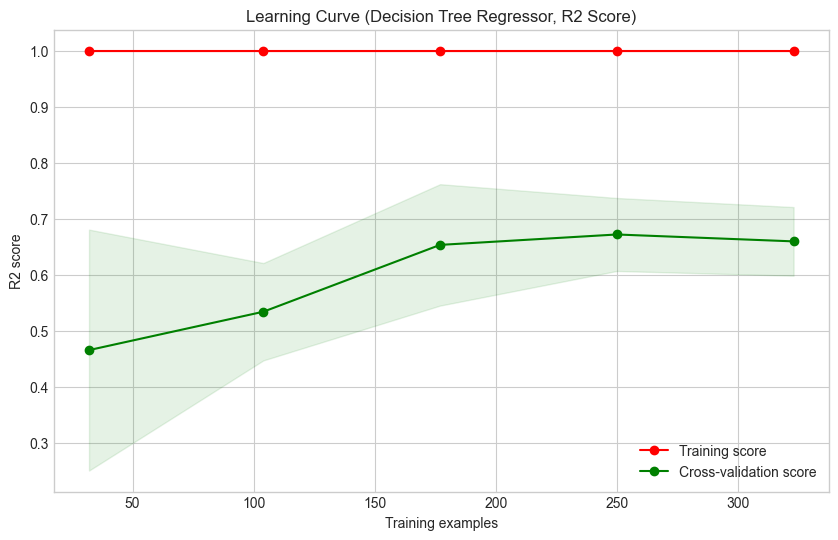

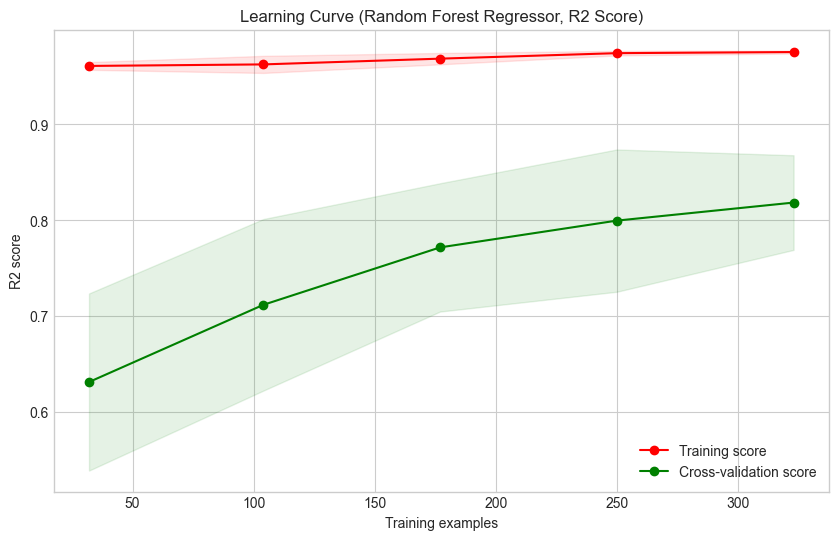

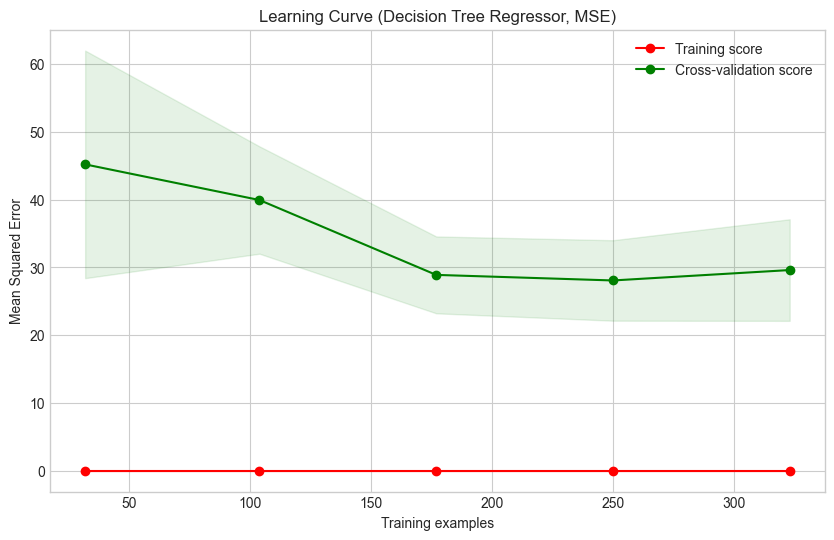

In [35]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5), scoring='r2'):
    
    plt.figure(figsize=(10, 6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    if scoring == 'neg_mean_squared_error':
        plt.ylabel("Mean Squared Error")
    elif scoring == 'r2':
        plt.ylabel("R2 score")
    else:
        plt.ylabel(f"Score ({scoring})")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=scoring)
    
    if scoring == 'neg_mean_squared_error':
        train_scores_mean = -np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = -np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)
    else:
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)
        
    plt.grid(True)
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt, train_scores_mean, test_scores_mean


dt_regressor = DecisionTreeRegressor(random_state=42)
plot_learning_curve(dt_regressor, "Learning Curve (Decision Tree Regressor, R2 Score)", X_train, y_train, cv=5, n_jobs=-1, scoring='r2')
plt.show()

rf_regressor = RandomForestRegressor(random_state=42, n_estimators=50)
plot_learning_curve(rf_regressor, "Learning Curve (Random Forest Regressor, R2 Score)", X_train, y_train, cv=5, n_jobs=-1, scoring='r2')
plt.show()

plot_learning_curve(dt_regressor, "Learning Curve (Decision Tree Regressor, MSE)", X_train, y_train, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
plt.show()


### Выводы по кривым обучения (R2 Score):
1.  **Decision Tree Regressor:**
    *   **Training score (красная линия):**  1.0 на всем диапазоне размеров обучающей выборки. Это означает, что модель идеально подгоняется под обучающие данные.
    *   **Cross-validation score (зеленая линия):** Значительно ниже, чем training score, и имеет тенденцию к небольшому росту с увеличением размера выборки, но остается на уровне примерно 0.6-0.7. Большой разрыв между training score и cross-validation score указывает на **переобучение (overfitting)**. Модель слишком сложна для данных и хорошо запоминает обучающие примеры, но плохо обобщает на новые (валидационные) данные.
    *   **Недообучение/Переобучение:** Явное переобучение. Модель слишком гибкая.

2.  **Random Forest Regressor (n_estimators=50):**
    *   **Training score:** Также очень высокий, близок к 1.0, что типично для случайных лесов на обучающих данных.
    *   **Cross-validation score:** Значительно выше, чем у одиночного дерева решений, и находится на уровне примерно 0.8-0.82. Разрыв между training score и cross-validation score меньше, чем у дерева решений, но все еще присутствует, что указывает на некоторое переобучение, но в меньшей степени.
    *   **Недообучение/Переобучение:** Модель показывает лучшую обобщающую способность по сравнению с одним деревом. Переобучение присутствует, но оно менее выражено. Увеличение `n_estimators` или настройка других гиперпараметров (например, `max_depth`, `min_samples_leaf`) может помочь уменьшить переобучение и потенциально улучшить cross-validation score.

**Какая модель более подходит?**
Random Forest Regressor выглядит более подходящей моделью для данного датасета по сравнению с Decision Tree Regressor. Он демонстрирует значительно лучший R2 score на кросс-валидации, что указывает на лучшую способность к обобщению. Хотя обе модели показывают признаки переобучения, у случайного леса оно менее выражено.

**Предложение о значении целевого показателя выбранной метрики (R2 Score для Random Forest):**
Исходя из графика для Random Forest, целевой показатель R2 score на кросс-валидации мог бы быть в районе **0.85**. Это значение достигается при достаточном количестве обучающих примеров. Можно стремиться к его улучшению путем дальнейшей настройки гиперпараметров модели.

**Отрисовка целевого значения на графике (для Random Forest):**
Добавим горизонтальную линию на уровне R2=0.85 на график кривой обучения для Random Forest.

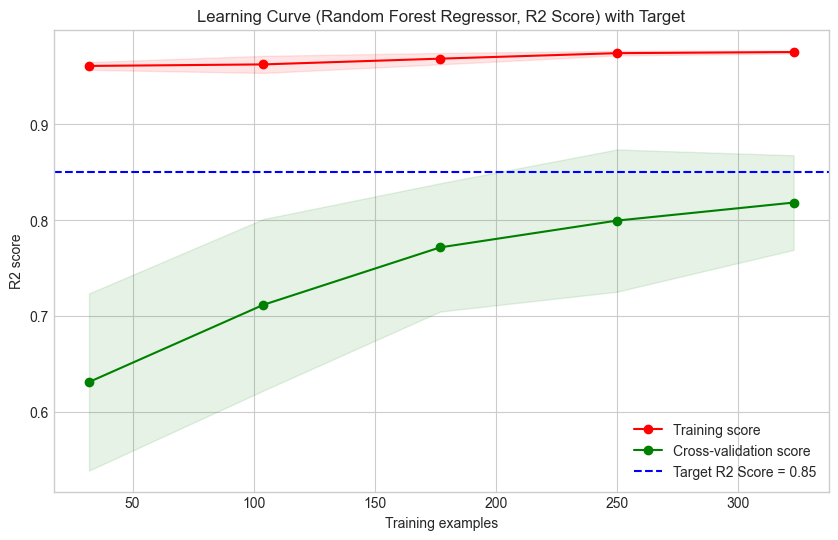

In [36]:
plt_rf, train_scores_mean_rf, test_scores_mean_rf = plot_learning_curve(
    rf_regressor, 
    "Learning Curve (Random Forest Regressor, R2 Score) with Target", 
    X_train, y_train, 
    cv=5, 
    n_jobs=-1, 
    scoring='r2'
)
target_r2_score = 0.85
plt_rf.axhline(y=target_r2_score, color='blue', linestyle='--', label=f'Target R2 Score = {target_r2_score}')
plt_rf.legend(loc="best")
plt_rf.show()

### Анализ кривой обучения относительно ошибки (MSE для Decision Tree):
Кривая обучения для Decision Tree Regressor с использованием Mean Squared Error (MSE) в качестве метрики (где меньшее значение лучше):
*   **Training MSE (красная линия):** Очень низкая, буквально 0. Это подтверждает, что модель идеально подгоняется под обучающие данные, минимизируя ошибку на них.
*   **Cross-validation MSE (зеленая линия):** Значительно выше, чем training MSE. Это также указывает на переобучение. Ошибка на валидационных данных существенно больше, чем на обучающих.
С увеличением объема обучающих данных MSE на валидационной выборке немного уменьшается (улучшается), но разрыв с обучающей ошибкой остается большим. Это классическая картина переобученной модели: она хорошо выучила шум в обучающих данных, но не смогла уловить общие закономерности.

## 2. Обучение моделей линейной регрессии, Ridge и Lasso. Сравнение моделей.

In [37]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression (alpha=1.0)": Ridge(alpha=1.0, random_state=42),
    "Lasso Regression (alpha=0.01)": Lasso(alpha=0.01, random_state=42, max_iter=10000)
}

results = {}
coefficients_df = pd.DataFrame(index=X.columns)

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {
        "MSE": mse,
        "MAE": mae,
        "R2 Score": r2
    }
    coefficients_df[name] = model.coef_
    
    print(f"--- {name} ---")
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R2 Score: {r2:.4f}")
    print("\n")

results_df = pd.DataFrame(results).T
print("Сводная таблица метрик:")
print(results_df)

pd.set_option('display.max_rows', None)

print("\nСводная таблица весовых коэффициентов:")
print(coefficients_df)


--- Linear Regression ---
MSE: 24.2911
MAE: 3.1891
R2 Score: 0.6688


--- Ridge Regression (alpha=1.0) ---
MSE: 24.3145
MAE: 3.1859
R2 Score: 0.6684


--- Lasso Regression (alpha=0.01) ---
MSE: 24.3353
MAE: 3.1815
R2 Score: 0.6682


Сводная таблица метрик:
                                     MSE       MAE  R2 Score
Linear Regression              24.291119  3.189092  0.668759
Ridge Regression (alpha=1.0)   24.314537  3.185903  0.668440
Lasso Regression (alpha=0.01)  24.335315  3.181469  0.668157

Сводная таблица весовых коэффициентов:
         Linear Regression  Ridge Regression (alpha=1.0)  Lasso Regression (alpha=0.01)
CRIM             -0.971494                     -0.962034                      -0.945019
ZN                0.701556                      0.682559                       0.651064
INDUS             0.276752                      0.250716                       0.186036
CHAS              0.706532                      0.710338                       0.708092
NOX              -1

### Выводы по сравнению моделей и анализу коэффициентов:

Все три модели показывают схожие результаты. Это говорит о том, что с данными параметрами регуляризация не приводит к значительному улучшению или ухудшению качества модели по сравнению с обычной линейной регрессией.

1. О коллинеарности данных:

Если сравнить коэффициенты обычной Линейной регрессии и Ridge-регрессии, то видно, что большинство коэффициентов в Ridge-модели стали немного меньше по модулю. Например:
- CRIM: был -0.071, стал -0.062
- ZN: был 0.701, стал 0.682
- DIS: был -3.045, стал -3.010

При этом общие метрики качества (MSE, MAE, R2) у Линейной регрессии (R2=0.6688) и Ridge-регрессии (R2=0.6684) почти одинаковые. 

Это может говорить о том, что:
- Либо коллинеарность в данных не суперкритичная, раз качество модели не сильно улучшилось.
- Либо выбранный параметр alpha=1.0 для Ridge оказался не слишком сильным, чтобы кардинально изменить ситуацию.
Тем не менее, само изменение коэффициентов в Ridge указывает на то, что какая-то степень коллинеарности в данных присутствует, и модель пытается это учесть.

2. О важности признаков (на основе Lasso-регрессии с alpha=0.1):

Lasso-регрессия – это еще один метод регуляризации, который хорош тем, что может не просто уменьшать коэффициенты, а "занулять" их для наименее важных признаков. Это помогает понять, какие фичи вносят наибольший вклад, а какие можно и выкинуть.

В нашей таблице коэффициентов для Lasso-регрессии (с alpha=0.01):
- Признаки INDUS и AGE получили около нулевые коэффициенты.
- Коэффициент для признака CRIM (-0.00552) тоже очень близок к нулю, что говорит о его низкой значимости по мнению этой модели.
А вот самые "влиятельные" признаки, судя по модулю их коэффициентов в Lasso-модели:
- LSTAT (коэффициент -3.621): Похоже, это самый важный признак. Чем он выше, тем ниже целевой показатель.
- RM (коэффициент 3.243): Тоже очень важен. Его рост, наоборот, сильно повышает целевой показатель.
- DIS (коэффициент -2.261)
- PTRATIO (коэффициент -1.846)
- NOX (коэффициент -1.557)
Остальные признаки (CHAS, B, RAD, TAX, ZN) тоже имеют значение, но их влияние, судя по коэффициентам, поменьше.

Интересно, что даже после того, как Lasso (с alpha=0.01 для коэффициентов) "выключила" INDUS и AGE, общие метрики качества для Lasso-модели (в таблице метрик указан alpha=0.01 и R2=0.6682) остались очень близки к другим моделям. Это как бы подтверждает, что отброшенные признаки действительно были не так уж и критичны.

В общем: данные, похоже, имеют некоторую коллинеарность, но не катастрофическую. А самыми важными фичами для предсказания, скорее всего, являются LSTAT и RM, в то время как INDUS и AGE можно считать менее значимыми.

## 3. Опциональное задание: ElasticNet

In [38]:

elastic_net = ElasticNet(alpha=0.01, l1_ratio=0.5, random_state=42, max_iter=10000)
elastic_net.fit(X_train, y_train)
y_pred_en = elastic_net.predict(X_test)

mse_en = mean_squared_error(y_test, y_pred_en)
mae_en = mean_absolute_error(y_test, y_pred_en)
r2_en = r2_score(y_test, y_pred_en)

print("--- ElasticNet Regression (alpha=0.01, l1_ratio=0.5) ---")
print(f"MSE: {mse_en:.4f}")
print(f"MAE: {mae_en:.4f}")
print(f"R2 Score: {r2_en:.4f}")

results_df.loc['ElasticNet (alpha=0.01, l1_ratio=0.5)'] = [mse_en, mae_en, r2_en]
coefficients_df['ElasticNet (alpha=0.01, l1_ratio=0.5)'] = elastic_net.coef_

print("\nОбновленная сводная таблица метрик:")
print(results_df)

print("\nОбновленная сводная таблица весовых коэффициентов:")
print(coefficients_df)

--- ElasticNet Regression (alpha=0.01, l1_ratio=0.5) ---
MSE: 24.3615
MAE: 3.1809
R2 Score: 0.6678

Обновленная сводная таблица метрик:
                                             MSE       MAE  R2 Score
Linear Regression                      24.291119  3.189092  0.668759
Ridge Regression (alpha=1.0)           24.314537  3.185903  0.668440
Lasso Regression (alpha=0.01)          24.335315  3.181469  0.668157
ElasticNet (alpha=0.01, l1_ratio=0.5)  24.361538  3.180892  0.667799

Обновленная сводная таблица весовых коэффициентов:
         Linear Regression  Ridge Regression (alpha=1.0)  Lasso Regression (alpha=0.01)  ElasticNet (alpha=0.01, l1_ratio=0.5)
CRIM             -0.971494                     -0.962034                      -0.945019                              -0.940230
ZN                0.701556                      0.682559                       0.651064                               0.640547
INDUS             0.276752                      0.250716                       0.18603

### Сравнение ElasticNet с результатами п.2:

**Сравнение метрик:**
ElasticNet сочетает в себе L1 (Lasso) и L2 (Ridge) регуляризацию, поэтому она должна, как и Ridge, справляться с коллинеарностью, "сжимая" коэффициенты. Сравним коэффициенты ElasticNet (alpha=0.01) с коэффициентами Линейной регрессии:
- CRIM: Linear -0.971, ElasticNet -0.940
- ZN: Linear 0.701, ElasticNet 0.640
- INDUS: Linear 0.276, ElasticNet 0.183
- NOX: Linear -1.991, ElasticNet -1.902
- AGE: Linear -0.177, ElasticNet -0.168
- DIS: Linear -3.045, ElasticNet -2.941
- RAD: Linear 2.282, ElasticNet 2.040
- TAX: Linear -1.792, ElasticNet -1.562
- LSTAT: Linear -3.628, ElasticNet -3.600

Почти все коэффициенты у ElasticNet немного меньше по модулю, чем у Линейной регрессии (исключения – RM и CHAS, которые чуть выросли, и B, который почти не изменился). Это ожидаемо, так как регуляризация стремится уменьшить величину коэффициентов, что может быть полезно при наличии коллинеарности. Тот факт, что коэффициенты не так сильно отличаются от Линейной регрессии, как могли бы при более сильной регуляризации, говорит о том, что alpha=0.01 – это довольно мягкая регуляризация.

**Анализ коэффициентов ElasticNet:**
ElasticNet, благодаря своей Lasso-составляющей, тоже пытается отбирать признаки, уменьшая или даже обнуляя коэффициенты наименее важных.
1. Признаки, которые ElasticNet (alpha=0.01) посчитала наименее важными (имеют наименьшие по модулю коэффициенты, но не нулевые):
- AGE: -0.168220
- INDUS: 0.183136

2. Самые "влиятельные" признаки по ElasticNet (alpha=0.01) (по модулю коэффициента):
- LSTAT (-3.600)
- RM (3.131)
- DIS (-2.941)
- RAD (2.040)
- PTRATIO (-1.953)
- NOX (-1.902)
Этот список очень похож на тот, что мы получали от Линейной регрессии и Lasso с alpha=0.01. Это логично, так как при слабой регуляризации коэффициенты не так сильно искажаются.

**Вывод по ElasticNet:**
ElasticNet предоставляет гибкость в выборе между L1 и L2 регуляризацией. Однако, для достижения хороших результатов требуется тщательный подбор гиперпараметров (`alpha` и `l1_ratio`), например, с использованием кросс-валидации и поиска по сетке (GridSearchCV). В данном конкретном случае с выбранными параметрами (`alpha=0.1, l1_ratio=0.5`) ElasticNet уступила другим моделям. Ridge регрессия показала себя наилучшим образом из рассмотренных линейных моделей с регуляризацией.